In [21]:
import pandas as pd
import numpy as np
import string as str
import sklearn.metrics as met
import sklearn.model_selection as ms
import sklearn.linear_model as linmod
import seaborn as sns

In [3]:
df = pd.read_csv("MarathonData.csv")
print(df)

    id  Marathon                     Name Category  km4week       sp4week  \
0    1  Prague17             Blair MORGAN      MAM    132.8     14.434783   
1    2  Prague17            Robert Heczko      MAM     68.6     13.674419   
2    3  Prague17            Michon Jerome      MAM     82.7     13.520436   
3    4  Prague17            Daniel Or lek      M45    137.5     12.258544   
4    5  Prague17             Luk ? Mr zek      MAM     84.6     13.945055   
5    6  Prague17             David Pecina      M40     42.2     13.612903   
6    7  Prague17             Tomas Drabek      M40     89.0     12.594340   
7    8  Prague17                 Jan Rada      M45    106.0     12.694611   
8    9  Prague17             Tomas Drabek      MAM     70.0     13.770492   
9   10  Prague17          martin ?indel ?      M45     84.2     13.365079   
10  11  Prague17           Maksim Remezau      MAM     93.5     13.200000   
11  12  Prague17       Jaroslaw Marchewka      M50     65.7     13.362712   

In [133]:
print(df.shape)
print('--------------------------------------------------------------------------------------------')
print(df.info()) #Find features which are not int/float, as they will need to be converted
print('--------------------------------------------------------------------------------------------')
print(df.describe())
print('--------------------------------------------------------------------------------------------')
print(df.isna().sum())
print('--------------------------------------------------------------------------------------------')
print('Full duplicate count= ', sum(df.duplicated()))

(87, 6)
--------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 6 columns):
Category        87 non-null int64
km4week         87 non-null float64
sp4week         87 non-null float64
Wall21          87 non-null float64
MarathonTime    87 non-null float64
CATEGORY        87 non-null int64
dtypes: float64(4), int64(2)
memory usage: 4.2 KB
None
--------------------------------------------------------------------------------------------
        Category     km4week   sp4week     Wall21  MarathonTime   CATEGORY
count  87.000000   87.000000  87.00000  87.000000     87.000000  87.000000
mean    2.022989   62.347126  12.10593   1.630617      3.319080   2.390805
std     1.397481   26.956019   1.19556   0.203014      0.376923   1.060455
min     1.000000   17.900000   8.03000   1.160000      2.370000   1.000000
25%     1.000000   44.200000  11.49500   1.490000      3.04500

In [6]:
#Drop id-like columns or columns which have very few values
df.drop(['id', 'Marathon', 'Name', 'CrossTraining'], axis='columns', inplace=True)

In [134]:
#Remove full duplicate rows
df.drop_duplicates(inplace=True)

In [8]:
#Replace missing values with mode
df['Category'].fillna(df['Category'].mode()[0], inplace=True)

#Label Encoding
df['Category'].replace(['MAM', 'M45', 'M40', 'M50', 'M55', 'WAM'], [1, 2, 3, 4, 5, 6], inplace=True)
df['CATEGORY'].replace(['A', 'B', 'C', 'D'], [1, 2, 3, 4], inplace=True)

#Replace hyphen in Wall21 with average
df.Wall21 = df.Wall21.str.strip()
avg = df[df.Wall21 != '-'].Wall21.astype(float).mean()
df.Wall21.replace('-', avg, inplace=True)

#Round values to 2 decimal places in sp4week. Remove one outlier
avg_sp4week = df[df.sp4week < 100].sp4week.mean()
df.loc[df.sp4week > 100, 'sp4week']= avg_sp4week
df.sp4week = round(df.sp4week, 2)

In [9]:
#Convert all object-type features to int/float
df.Wall21 = df.Wall21.astype(float) 
df.Category = df.Category.astype(int)
df.Wall21 = df.Wall21.astype(float)

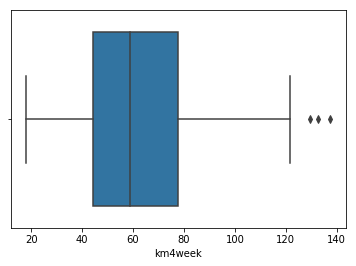

In [118]:
sns.boxplot(x=df["km4week"])

In [111]:
# Print outliers
for c in df.columns:
    df1 = pd.DataFrame(df[c])
        
    if df1[c].dtype != 'object':
        print('******** ', c, ' *********')
        q1 = df1[c].quantile(0.25)
        q3 = df1[c].quantile(0.75)
        iqr = q3 - q1
        low = q1 - (iqr * 1.5)
        high = q3 + (iqr * 1.5)
        avg = df1[c].mean()
        print('avg= ', avg, 'low= ', low, 'upper= ', upper)
        
        outliers_cnt = df1[(df1[c] < low) | (df1[c] > high)][c].count()  
        if  outliers_cnt > 0:
            print(outliers_cnt, ' outliers exist ... ')
            str_outliers = df1[(df1[c] < low) | (df1[c] > high)][c].to_string(index=False)
            str_outliers.replace('\n', ', ')
            print(str_outliers)
        else:
            print('No Outliers !')

********  Category  *********
avg=  2.0229885057471266 low=  -2.0 upper=  4.5
No Outliers !
********  km4week  *********
avg=  62.34712643678161 low=  -5.749999999999993 upper=  4.5
3  outliers exist ... 
132.8
137.5
129.6
********  sp4week  *********
avg=  12.105930232558137 low=  9.5675 upper=  4.5
3  outliers exist ... 
14.97
 8.03
 8.34
********  Wall21  *********
avg=  1.6306172839506174 low=  1.0925000000000002 upper=  4.5
No Outliers !
********  MarathonTime  *********
avg=  3.319080459770115 low=  2.205 upper=  4.5
No Outliers !
********  CATEGORY  *********
avg=  2.3908045977011496 low=  0.5 upper=  4.5
No Outliers !


In [135]:
df.cov()

,Category,km4week,sp4week,Wall21,MarathonTime,CATEGORY
Category,1.952954,5.647741,-0.137300,0.016338,0.000370,-0.020716
km4week,5.647741,726.626939,6.053411,-3.049843,-6.165119,-15.601190
sp4week,-0.137300,6.053411,1.429364,-0.144637,-0.277380,-0.730114
Wall21,0.016338,-3.049843,-0.144637,0.041215,0.072223,0.192939
MarathonTime,0.000370,-6.165119,-0.277380,0.072223,0.142071,0.383271
CATEGORY,-0.020716,-15.601190,-0.730114,0.192939,0.383271,1.124566


In [112]:
#Split data frame into two- one with all the features (dfx) and one with just the target variable (dfy)
fcols = ['Category', 'km4week', 'sp4week', 'Wall21', 'CATEGORY']
dfx = df[fcols]
dfy = df['MarathonTime']

#Split dfx into train & test rows, similarly dfy into train & test rows. Split % = 025%
dfx_train, dfx_test, dfy_train, dfy_test = ms.train_test_split(dfx, dfy, random_state=123)

In [113]:
print(dfx_train.shape)
print(dfx_test.shape)
print(dfy_train.shape)
print(dfy_test.shape)

(65, 5)
(22, 5)
(65,)
(22,)


In [50]:
print(dfx_train)

    Category  km4week    sp4week Wall21  CATEGORY
65         2     60.3  11.708738   1.88         3
31         1     79.4  13.344538   1.60         2
24         1     67.4  12.878981   1.52         2
41         5     58.8  12.829091   1.68         2
9          2     84.2  13.365079   1.35         1
21         3     67.3  13.239344   1.50         2
62         2     48.8  11.665339   1.66         3
19         1     76.7   8.031414   1.41         1
75         1     23.9  12.050420   1.85         4
85         2     33.2  11.066667   2.05         4
50         1     50.3  10.161616   1.67         3
76         1     40.3   8.337931   1.94         4
20         1     94.5  11.886792   1.45         1
78         1     28.0  11.200000   1.97         4
1          1     68.6  13.674419   1.23         1
70         2     87.0  11.472527   1.81         4
74         1     66.7  11.566474   1.90         4
14         1     76.8  12.943820   1.44         1
69         1     41.6  12.235294   1.80         3


In [114]:
linreg = linmod.LinearRegression()
linreg.fit(dfx_train, dfy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
print(linreg.coef_)
print(linreg.intercept_)

[ 0.00706337 -0.00127327 -0.01795788  0.79822987  0.17481837]
1.8820964609253217


In [115]:
dfy_test_pred = linreg.predict(dfx_test)
dfy_train_pred = linreg.predict(dfx_train)

In [116]:
mse_train_pred = met.mean_squared_error(dfy_train, dfy_train_pred)
mse_test_pred = met.mean_squared_error(dfy_test, dfy_test_pred)

print("MSE of train & pred= ", mse_train_pred)
print("MSE of test & pred= ", mse_test_pred)

MSE of train & pred=  0.004867751469141443
MSE of test & pred=  0.007233634082200017
